<a href="https://colab.research.google.com/github/otakunoichin/test/blob/main/AI%E7%B6%B2%E8%86%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt


In [11]:
from google.colab import drive
drive.mount('/content/drive')

ROOT = Path("/content/drive/MyDrive/ai_dataset")
IMG_DIR = ROOT / "images"
LBL_DIR = ROOT / "labels"

assert IMG_DIR.exists(), IMG_DIR
assert LBL_DIR.exists(), LBL_DIR

print("IMG_DIR:", IMG_DIR)
print("LBL_DIR:", LBL_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IMG_DIR: /content/drive/MyDrive/ai_dataset/images
LBL_DIR: /content/drive/MyDrive/ai_dataset/labels


In [ ]:
img_map = {p.stem: p for p in IMG_DIR.glob("*.jpg")}
lbl_map = {p.stem: p for p in LBL_DIR.glob("*.tif")}

common_ids = sorted(set(img_map) & set(lbl_map))
pairs = [(img_map[i], lbl_map[i]) for i in common_ids]

print("images:", len(img_map))
print("labels:", len(lbl_map))
print("paired :", len(pairs))
print("example ids:", common_ids[:10])


images: 20
labels: 35
paired : 20
example ids: ['001', '002', '004', '005', '006', '007', '011', '016', '024', '026']


img shape : (4000, 4000) dtype: uint8 min/max: 0 255
mask shape: (4000, 4000) dtype: uint8 unique (sample): [  0 255]


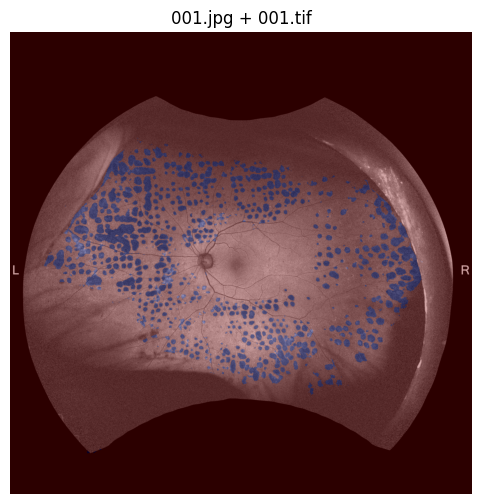

In [ ]:
def read_gray(path: Path):
    # jpg/tif問わずグレースケールで読む
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"failed to read: {path}")
    return img

def show_overlay(img, mask, title="overlay"):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.35)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 先頭のペアで確認
img_path, mask_path = pairs[0]
img = read_gray(img_path)
mask = read_gray(mask_path)

print("img shape :", img.shape, "dtype:", img.dtype, "min/max:", img.min(), img.max())
print("mask shape:", mask.shape, "dtype:", mask.dtype, "unique (sample):", np.unique(mask)[:10])

# マスクを2値化（>0 を True）
mask_bin = (mask > 0).astype(np.uint8)

# サイズが違う場合は、とりあえず「表示用」にマスクを画像サイズへ
mask_for_vis = mask_bin
if mask_for_vis.shape != img.shape:
    mask_for_vis = cv2.resize(mask_for_vis, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

show_overlay(img, mask_for_vis, title=f"{img_path.name} + {mask_path.name}")

In [ ]:
PATCH_ROOT = ROOT / "patches_512"
PATCH_IMG_DIR = PATCH_ROOT / "images"
PATCH_MSK_DIR = PATCH_ROOT / "masks"
PATCH_IMG_DIR.mkdir(parents=True, exist_ok=True)
PATCH_MSK_DIR.mkdir(parents=True, exist_ok=True)

TARGET = 4096
PATCH = 512
GRID = TARGET // PATCH  # 8

def reflect_pad_to(img, target=4096):
    h, w = img.shape[:2]
    assert h <= target and w <= target
    pad_h = target - h
    pad_w = target - w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(img, ((top, bottom), (left, right)), mode="reflect")

def make_patches_one(img, mask_bin, img_id: str):
    # img: uint8 gray, mask_bin: {0,1} uint8 gray
    img_p = reflect_pad_to(img, TARGET)
    msk_p = reflect_pad_to(mask_bin, TARGET)

    # パッチ切り出し
    count = 0
    for r in range(GRID):
        for c in range(GRID):
            y0, y1 = r*PATCH, (r+1)*PATCH
            x0, x1 = c*PATCH, (c+1)*PATCH
            ip = img_p[y0:y1, x0:x1]
            mp = msk_p[y0:y1, x0:x1]

            out_img = PATCH_IMG_DIR / f"image_{img_id}_row{r}_col{c}.png"
            out_msk = PATCH_MSK_DIR / f"mask_{img_id}_row{r}_col{c}.png"
            cv2.imwrite(str(out_img), ip)
            cv2.imwrite(str(out_msk), (mp*255).astype(np.uint8))
            count += 1
    return count

# 全ペアをパッチ化
total_patches = 0
for img_path, mask_path in pairs:
    img_id = img_path.stem  # "001" etc
    img = read_gray(img_path)
    mask = read_gray(mask_path)
    mask_bin = (mask > 0).astype(np.uint8)

    # ★重要：サイズが一致しない場合は「まず同じサイズに揃える」
    if mask_bin.shape != img.shape:
        mask_bin = cv2.resize(mask_bin, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    total_patches += make_patches_one(img, mask_bin, img_id)

print("total_patches:", total_patches)
print("expected per image:", 64, "=> expected total =", 64 * len(pairs))


OSError: [Errno 30] Read-only file system: '/content/drive/MyDrive/ai_dataset/patches_512'